<a href="https://colab.research.google.com/github/notdibya/gcsl/blob/master/GCSLDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal-Conditioned Supervised Learning (GCSL)

<a href="https://ibb.co/gz3HWFD"><img src="https://i.ibb.co/J5K0pFz/gcsl-figure-arxiv.png" alt="gcsl-figure-arxiv" border="0" /></a>

This notebook provides a brief introduction to goal-conditioned supervised learning (GCSL), as introduced in 
> Dibya Ghosh, Abhishek Gupta, Justin Fu, Ashwin Reddy, Coline Devin, Benjamin Eysenbach, Sergey Levine. *Learning To Reach Goals Without Reinforcement Learning.*

In this notebook, we develop a simple instantiation of the GCSL algorithm for solving goal-reaching tasks on a simple 2d navigation task with discrete actions to explain the algorithm. For a codebase with more complete features, please see the Github repository linked below.

Other useful links:
- [ArXiv paper](https://arxiv.org/abs/1912.06088)
- [Github](https://github.com/notdibya/gcsl/)
- [Interactive Colab](https://colab.research.google.com/github/notdibya/gcsl/blob/master/GCSLDemo.ipynb) (follow along with the code)

Let's get started!


## The Goal-Reaching Problem

Goal-conditioned supervised learning (GCSL) is an algorithm for solving the problem of goal-reaching in an environment (formally, an MDP). 

At the beginning of each episode, a goal state $g$ is selected randomly in an environment and shown to the agent. The agent's goal is to reach this goal state by the end of the episode, which terminates after some fixed amount of time has passed.

Each step, the agent must choose an action to take, given three pieces of information:

1. The **state** the agent is currently at
2. The **goal** the agent is trying to get to
3. The amount of time the agent has left to reach the goal (the **horizon**)

For example, here would be the pseudocode of an agent that takes actions randomly.

```python
class RandomAgent:
  def get_action(self, state, goal, horizon):
    return np.random.choice(n_actions) # Choose randomly
```

How can we train an agent $\pi: (s, g, h) \mapsto a$ to learn to reach goals in the environment? 

**RL**: The dominant paradigm is reinforcement learning (RL), where you define a *reward* function $r(s, g) = \begin{cases} 1 & s=g \\ 0 & \text{otherwise}\end{cases}$, and optimize this agent using a value-based RL algorithm (DQN, DDPG, TD3, SAC). This can get quite complicated, and is often difficult to learn in practice.


**Imitation Learning**: If instead, we had access (somehow) to an optimal policy $\pi^*$, that given any state $s$, goal $g$ and time horizon $h$, could return the optimal action $a^*$, we could just use supervised learning to try to match the actions of the expert (MLE). If actions were discrete, this would correspond to a classification problem, and if actions were continuous, this would correspond to a regression problem.

## Goal-Conditioned Supervised Learning (GCSL)

Of course, we don't have access to the optimal policy $\pi^*$ (wouldn't life be simple, then?). What can we do in the absence of this optimal policy? GCSL leverages the insight that even if we don't have access to the optimal policy, we can use **the principle of hindsight** to turn data that the agent has collected into "optimal" data.


**The Principle of Hindsight**: Suppose the agent has just executed the following episode. It was commanded to reach the goal $g^*$, and ends up seeing the following states and taking the following actions

$$s_0, a_0, s_1, a_1, s_2, \dots s_{50}, a_{50}$$

The agent might have done a terrible job at reaching $g^*$. It could be that the final state $s_{50}$ and $g^*$ are on opposite sides of the room. However, we know that the agent was able to successfully reach $s_{50}$, and we can use the data collected in the trajectory to teach the agent how to better get to $s_{50}$. 

For that matter, the agent was also able to reach $s_{49}, s_{48}, \dots$, and we can use this data to learn how to reach all of these states  more accurately.

More precisely, consider any two timesteps $t_1$ and $t_2$ ($t_1 < t_2$). We know that after the agent took action $a_{t_1}$ in state $s_{t_1}$, it reached the state $s_{t_2}$ after $t_2-t_1$ timesteps. This means that we can treat $a_{t_1}$ as being **optimal** behavior at $s_{t_1}$ when trying to reach $s_{t_2}$ in $t_2 - t_1$ timesteps.

**GCSL:** The algorithm performs a simple three-step procedure:

1. Collects a trajectory with the current agent
2. Picks many choices of $t_1,t_2$ to create a dataset $\mathcal{D}$ of optimal data $\mathbf{x} = (s=s_{t_1}, g=s_{t_2}, h=t_2-t_1)$ and $\mathbf{y} = a_{t_1}$.
3. Performs supervised learning (classification or regression depending on discrete actions) to have the policy produce output $\mathbf{y}$ when provided input $\mathbf{x}$.

Formally, the policy is performing maximum-likelihood estimation (MLE) via supervised learning.

$$\arg\max_\theta \mathbb{E}_{((s,g,h), a) \sim \mathcal{D}}[\log \pi_\theta(a | s=s, g=g, h=h)]$$

## GCSL in Code

Now having provided a general overview of the algorithm, let's see a simple implementation of GCSL with a neural network agent trained in Pytorch, learning to reach goals in a pointmass navigation environment. 

In [0]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import gym

## The Environment
We use a navigation task in a room to illustrate GCSL. The agent, which gets to observe its $(x,y)$ coordinates, can take one of 5 actions: go up, right, down, left or stay still.


The environment defined below is simply a normal Gym env, but with one new function:
- `env.sample_goal()`: To define the goal reaching task, we need a notion of what goals the agent should try to reach. This function samples one such *desired goal*. In this case, a goal position is chosen randomly in the room.

We also implement a helper function for visualizing data from this environment. The agent starts in the blue square, and attempts to reach the orange star.

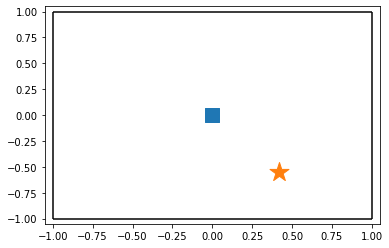

In [24]:
# @title Environment Definition

import matplotlib.pyplot as plt
import gym

class PointmassEnv(gym.Env):
  def __init__(self):
    # 2-d coordinates
    self.observation_space = gym.spaces.Box(-1, 1, shape=(2,), dtype=np.float32)
    self.position = np.zeros(2) 
    # Up, Right, Down, Left, Stay
    self.action_space = gym.spaces.Discrete(5)

  def reset(self):
    self.position = np.zeros(2)
    return self.position

  def action_to_direction(self, a):
    actions = [
               np.array([0, 1]), # Up
               np.array([1, 0]), # Right
               np.array([0, -1]), # Down
               np.array([-1, 0]), # Left,
               np.array([0, 0]), # Stay still
    ]
    return actions[a]
  
  def step(self, a):
    direction = self.action_to_direction(a)
    step = 0.05 * direction + np.random.randn() * 0.01 # Take a noisy step in direction
    self.position = self.position + step
    self.position = np.clip(self.position, -1, 1) # Clip to prevent object from escaping
    return (self.position, # State
          0,     # Reward (not necessary for GCSL)
          False, # Done flag
          dict()) # Additional info 

  def sample_goal(self):
    return np.random.rand(2) * 2 - 1 # Sample uniformly from [-1, 1]


def plot_trajectory(trajectory, ax=None):
  if ax is None:
    ax = plt.gca()
  # Draw path
  ax.plot(*trajectory['states'].T)
  # Draw goal
  ax.scatter(0, 0, s=200, marker='s')
  ax.scatter(trajectory['desired_goal'][0], trajectory['desired_goal'][1], s=400, marker='*')
  # Draw boundary
  ax.vlines([-1, 1], -1, 1)
  ax.hlines([-1, 1], -1, 1)

  ax.set_xlim(-1.05, 1.05)
  ax.set_ylim(-1.05, 1.05)
  ax.axis('off')

env = PointmassEnv()
plot_trajectory(dict(states=env.reset()[None], desired_goal=env.sample_goal()))
plt.axis('on');

## The Agent

Our agent must choose an action to take, given three pieces of information
1. The **state** the agent is currently at
2. The **goal** the agent is trying to get to
3. The amount of time the agent has left to reach the goal (the **horizon**)

Our agent's policy will be determined by a neural network. This agent takes in the state, goal, and horizon; concatenates them all together; and feeds this input into a neural network with two hidden layers of size 100 each. The neural network outputs logits for each action. The agent will sample according to the logits to output the action.

Neural Network Schema (see code below for more details):

```
self.net = nn.Sequential(
      nn.Linear(5, 100), # Input 2 (state) + 2 (goal) + 1 (horizon)
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 5), # Output: logits for 5 actions
)
```


In [0]:
#@title Neural Network Agent Definition

class NNAgent(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(5, 100), # Input 2 (state) + 2 (goal) + 1 (horizon)
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 5), # Output: 5 actions
      )
  
  def forward(self, state, goal, horizon):
    horizon = horizon / 50 # Normalize between [0, 1]
    x = torch.cat([state, goal, horizon], -1)
    logits = self.net(x)
    return logits
  
  def get_action(self, state, goal, horizon):
    # Put into PyTorch Notation
    state_torch, goal_torch, horizon_torch = to_torch(state, goal, horizon)
    logits_torch = self.forward(state_torch, goal_torch, horizon_torch)[0]
    probabilities_torch = torch.softmax(logits_torch, -1)
    probabilities = probabilities_torch.detach().numpy()
    
    return np.random.choice(5, p=probabilities)
  

def to_torch(state, goal, horizon):
  state_torch = torch.tensor(state, dtype=torch.float32)[None]
  goal_torch = torch.tensor(goal, dtype=torch.float32)[None]
  horizon_torch = torch.tensor(horizon, dtype=torch.float32)[None, None]
  return state_torch, goal_torch, horizon_torch

## Acting in the Environment

At the beginning of each episode, we choose a desired goal (according to `env.sample_goal()`). The agent interacts with the environment (in the typical RL fashion) trying to reach this goal by the last timestep of this episode (total 50 timesteps).

The function `sample_trajectory(env, agent)` executes an episode according to the above logic and returns the states seen, the actions the agent took, and what the desired goal was.


In [0]:
# @title Agent-Environment Interaction

def sample_trajectory(env, agent, T=50):
  # Sample a target goal (fixed for episode)
  desired_goal = env.sample_goal()

  # Default control loop
  state = env.reset()
  states = []
  actions = []
  for i in range(T):
    states.append(state)

    action = agent.get_action(state=state,
                              goal=desired_goal,
                              horizon=np.array(T-i, dtype=float))
    actions.append(action)

    state, _, _, _ = env.step(action)

  return {
      'states': np.array(states),  
      'actions': np.array(actions),
      'desired_goal': desired_goal,
  }



We also write some code to evaluate the performance of the agent. We will measure performance according to how far the agent was from the desired goal at the final state in the episode.

- `evaluate_agent` collects 50 episodes, and prints the median distance to goal for the agent.
- `visualize_agent` visualizes 5 different episodes, each with a different goal, for the agent.



In [0]:
def evaluate_agent(env, agent, n=50):
  distances = []
  for _ in range(n):
    trajectory = sample_trajectory(env, agent)
    distances.append(np.linalg.norm(trajectory['states'][-1] - trajectory['desired_goal']))
  print('Median Distance to Goal:  %.3f'% np.median(distances))
  print('Min Distance to Goal:  %.3f'% np.min(distances))
  print('Max Distance to Goal:  %.3f'% np.max(distances))

def visualize_agent(env, agent):
  fig, axes = plt.subplots(1, 5, figsize=(15, 3))
  for ax in axes:
    plot_trajectory(sample_trajectory(env, agent), ax=ax)
  

Median Distance to Goal:  0.780
Min Distance to Goal:  0.195
Max Distance to Goal:  1.566


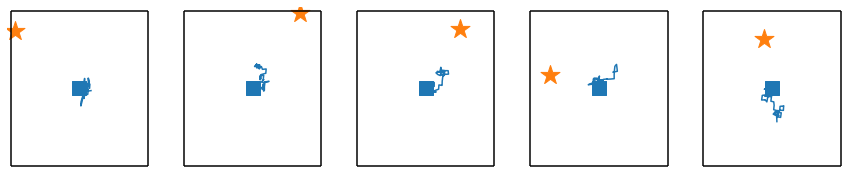

In [18]:
env = PointmassEnv()
agent = NNAgent()

evaluate_agent(env, agent)
visualize_agent(env, agent)

## Learning a Policy using GCSL (A Code Description)

Now that we've established the basics of what an *agent* is, how it interacts with the environment, and how to evaluate the agent, let's actually train a policy!

Suppose that the agent has already collected some trajectories in its buffer.
```
buffer = []
for i in range(10):
  buffer.append(sample_trajectory(env, agent))
```

When training the policy, we will sample a trajectory randomly from the dataset
```
trajectory = buffer[np.random.choice(len(buffer))]
```
Choose two time-steps randomly on this path $t_1 < t_2$ (remember, hindsight works for any trajectory and any such pair).
```
t1, t2 = np.random.randint(0, 50, size=2)
t1, t2 = min([t1, t2]), max([t1, t2])
```

If we define
- `s` to be the state at t1
- `a` to be the action at t1
- `g` to be the state at t2
- `h` to be t2 - t1

```
s = trajectory['states'][t1]
a = trajectory['actions'][t1]
g = trajectory['states'][t2]
h = t2 - t1
```


Then `a` is a good action to go from `s` to `g` in `h` timesteps.

Because of this, we can treat it as expert data for `agent(state=s, goal=g, horizon=h)`, and try to match it using the classification loss.


```
  loss = nn.functional.cross_entropy(agent(s, g, h), a)
```

This leads to the following code-block that fully describes the GCSL algorithm:

##### Episode 0 #####
Median Distance to Goal:  0.756
Min Distance to Goal:  0.098
Max Distance to Goal:  1.400
##### Episode 40 #####
Median Distance to Goal:  0.357
Min Distance to Goal:  0.037
Max Distance to Goal:  1.073
##### Episode 80 #####
Median Distance to Goal:  0.135
Min Distance to Goal:  0.016
Max Distance to Goal:  0.500
##### Episode 120 #####
Median Distance to Goal:  0.128
Min Distance to Goal:  0.003
Max Distance to Goal:  0.283
##### Episode 160 #####
Median Distance to Goal:  0.096
Min Distance to Goal:  0.010
Max Distance to Goal:  0.372
##### Episode 200 #####
Median Distance to Goal:  0.100
Min Distance to Goal:  0.015
Max Distance to Goal:  0.251


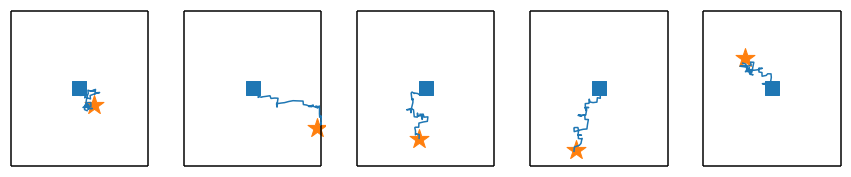

In [20]:
# Create agent and optimizer

agent = NNAgent()
learning_rate = 1e-4
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

buffer = []
n_episodes = 201
n_steps_per_episode = 500

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  new_trajectory = sample_trajectory(env, agent)
  buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer.zero_grad()
    loss = nn.functional.cross_entropy(agent(s, g, h), a)
    loss.backward()
    optimizer.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent)

visualize_agent(env, agent)

When you run the previous cell, you should see the GCSL agent learning how to reach all the states in the room! And that's it!

If you're interested in learning more about how *why* this simple procedure works, check out our [paper](https://arxiv.org/abs/1912.06088). If you're looking to apply the algorithm on larger domains, check out our [Github repository](https://github.com/notdibya/gcsl)


